
<div style="text-align: center; line-height: 0; padding-top: 9px;">  
  <img src="/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/MyProducePal_Logo.PNG" alt="Image">  
</div> 

# This notebook is developed to read weights of pre-trained PyTorch Model VGG16 and fine tune it using Fruits 360 dataset.

In [0]:
pip install torchinfo

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached torchinfo-1.8.0-py3-none-any.whl (23 kB)
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.utils.data.dataloader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets
import os
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Tuple,Dict,List
from tqdm.auto import tqdm
from timeit import default_timer as timer
import torchvision
import random
from pathlib import Path

In [0]:
import csv
results_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/test_results_vgg16_finetuned.csv'
df_result = pd.read_csv(results_path)
df_result

,Index,Actual Label,Predicted Label
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
23614,30,140,140
23615,31,140,140
23616,0,140,140
23617,1,140,140


In [0]:
#if you dont know you can download datasets with kaggle library 
# !pip install kaggle

In [0]:
# !mkdir kaggle

In [0]:
# !kaggle datasets download moltean/fruits

In [0]:
# !unzip -o "fruits.zip" -d "/kaggle/"

In [0]:
# rm -rf "kaggle/fruits-360-original-size"

In [0]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [0]:
#define dataloader and class_names
def create_dataloaders(
    train_dir:str,
    test_dir:str,
    train_transforms:transforms.Compose,
    test_transforms:transforms.Compose,
    batch_size:int,
    num_workers:int=2
):
    #select all image and implement selected transform and turn into tensor
    train_data=datasets.ImageFolder(train_dir,transform=train_transforms)
    test_data=datasets.ImageFolder(test_dir,transform=test_transforms)

    #ImageFolder class have a variable about folder names under the selected path
    class_names=train_data.classes


    train_dataloader=DataLoader(
        train_data,
        batch_size=batch_size, #how many image should select in each iter
        shuffle=True, #mix the data
        num_workers=num_workers,
        pin_memory=True
    )

    test_dataloader=DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_dataloader,test_dataloader,class_names

In [0]:
#path: /Volumes/cmidev/default/preventech/data/user_files/gf591/ML/fruits-360/Training/
data_path=Path("/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/")
train_dir=data_path /"Training"
test_dir=data_path /"Test"


In [0]:

# #Get the pretrained model
# weights=torchvision.models.GoogLeNet_Weights.DEFAULT
# auto_transforms=weights.transforms()

# train_dataloader,test_dataloader,class_names=create_dataloaders(train_dir=train_dir,
#                                                                 test_dir=test_dir,
#                                                                 train_transforms=auto_transforms,
#                                                                 test_transforms=auto_transforms,
#                                                                 batch_size=32)

In [0]:
# type(train_dataloader)

torch.utils.data.dataloader.DataLoader

tensor([ 39,  14, 121, 130,   1,  24, 101, 113,  14,  82,  83, 102,  94,  16,
        124,  90,  72,  64,  45,  64,  62, 110,  17, 138,  17,  61,  91,  52,
         44,  54, 120,  21])


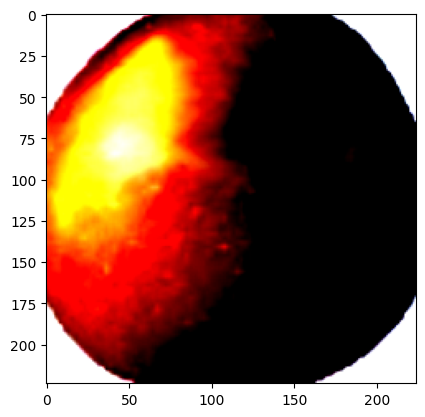

In [0]:
import torch  
import matplotlib.pyplot as plt  
import numpy as np  
  
# Get the first batch of images from the dataloader  
images, labels = next(iter(train_dataloader))  
print(labels)
# Select the first image in the batch  
image = images[4]  
  
# Convert the PyTorch tensor to a numpy array  
image = np.transpose(image.numpy(), (1, 2, 0))  
  
# Plot the image  
plt.imshow(image)  
plt.show()  

In [0]:
class_names

['Apple 6',
 'Apple Braeburn 1',
 'Apple Crimson Snow 1',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith 1',
 'Apple Pink Lady 1',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious 1',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apple hit 1',
 'Apricot 1',
 'Avocado 1',
 'Avocado ripe 1',
 'Banana 1',
 'Banana Lady Finger 1',
 'Banana Red 1',
 'Beetroot 1',
 'Blueberry 1',
 'Cabbage white 1',
 'Cactus fruit 1',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula 1',
 'Carrot 1',
 'Cauliflower 1',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier 1',
 'Cherry Wax Black 1',
 'Cherry Wax Red 1',
 'Cherry Wax Yellow 1',
 'Chestnut 1',
 'Clementine 1',
 'Cocos 1',
 'Corn 1',
 'Corn Husk 1',
 'Cucumber 1',
 'Cucumber 3',
 'Cucumber Ripe 1',
 'Cucumber Ripe 2',
 'Dates 1',
 'Eggplant 1',
 'Eggplant long 1',
 'Fig 1',
 'Ginger Root 1',
 'Granadilla 1',
 'Grape Blue 1',
 'Grape Pink 1',
 'Grape White 1',
 'Grape White 2',
 'Grape White 3',
 'Grape White

In [0]:
len(class_names)

141

In [0]:
# model=torchvision.models.googlenet(weights=weights)
# for param in model.parameters():
#     param.requires_grad = False

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 48.9MB/s]


In [0]:
#Get the pretrained model
weights=torchvision.models.VGG16_Weights.DEFAULT

auto_transforms=weights.transforms()

train_dataloader,test_dataloader,class_names=create_dataloaders(train_dir=train_dir,
                                                                test_dir=test_dir,
                                                                train_transforms=auto_transforms,
                                                                test_transforms=auto_transforms,
                                                                batch_size=32)
model_vgg16=torchvision.models.vgg16(weights=weights)
for param in model_vgg16.parameters():
    param.requires_grad = False

In [0]:
from torchinfo import summary
summary(model=model_vgg16,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

/databricks/python/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   False
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (6)

# Baseline:
Below model is to modify the fully connected (fc) layer of a pre-trained GoogleNet model in PyTorch by adding layers as below:
1. First layer is added to the sequential module with 1024 input features and 512 output features.
2. To reduce non-linearity and improve learning of model on complex patterns, a ReLu activation function is added in second layer to act on the output of the first layer
3. Third layer is added with drop out to reduce overfitting of the model by randomly dropping out some of the neurons during training for regularization.
4. Forth layer is added to generate output having total classes = number of classes in original dataset.
5. Last layer is added to take Log of SoftMax function on probability of the prediction belonging to each class.
By doing this, in this baseline model is  replacing the original fc layer of the pre-trained GoogleNet model with the new sequential module. 

In [0]:
model_vgg16.fc = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(512, len(class_names)),
                                 nn.LogSoftmax(dim=1)).to(device)

In [0]:
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(params=model_vgg16.parameters(),lr=0.001)


In [0]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch,(image,label) in enumerate(data_loader):
        image,label=image.to(device),label.to(device)
        
        y_pred=model(image)
        
        loss=loss_fn(y_pred,label)
        
        train_loss+=loss.item()
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        
        y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc +=(y_pred_class==label).sum().item()/len(y_pred)
        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader) 
    return train_loss,train_acc

def test_step(model:torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device:torch.device =device): 
    test_loss,test_acc=0,0
    
    model.eval()
    with torch.inference_mode():
        for batch,(image,label) in enumerate(data_loader):
            image,label=image.to(device),label.to(device)
            
            test_pred_logits=model(image)
            
            loss=loss_fn(test_pred_logits,label)
            test_loss += loss.item()
            
            test_pred_labels=test_pred_logits.argmax(dim=1)
            
            test_acc+= ((test_pred_labels==label).sum().item()/len(test_pred_labels))
            
        test_loss/=len(data_loader)
        test_acc/=len(data_loader)
    return test_loss,test_acc   

def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          epochs:int=5,
          device=device):
    results={"train_loss":[],
             "train_acc":[],
             "test_loss":[],
             "test_acc":[]}
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model=model,
                                       data_loader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
        test_loss,test_acc=test_step(model=model,
                                       data_loader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
        print(f"Epoch:{epoch}| train_loss:{train_loss:.4f}|train_acc:{train_acc:.4f}|test_loss:{test_loss:.4f}|test_acc:{test_acc:.4f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results


In [0]:
%python
model_vgg16 = model_vgg16.requires_grad_(True)

In [0]:
from timeit import default_timer as timer
start_time=timer()
device = "cuda" if torch.cuda.is_available() else "cpu"
results=train(model=model_vgg16,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=10,
                    device=device)
end_time=timer()
print(f"[INFO]Total training time= {end_time-start_time:.3f} seconds")

# 5/5 [25:16<00:00, 302.51s/it]
# Epoch:0| train_loss:1.3318|train_acc:0.6648|test_loss:0.4805|test_acc:0.8802
# Epoch:1| train_loss:0.1989|train_acc:0.9445|test_loss:0.4788|test_acc:0.8906
# Epoch:2| train_loss:0.1680|train_acc:0.9587|test_loss:0.5093|test_acc:0.9036
# Epoch:3| train_loss:0.1230|train_acc:0.9700|test_loss:0.3074|test_acc:0.9271
#[INFO]Total training time= 1516.539 seconds

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0| train_loss:1.3318|train_acc:0.6648|test_loss:0.4805|test_acc:0.8802
Epoch:1| train_loss:0.1989|train_acc:0.9445|test_loss:0.4788|test_acc:0.8906
Epoch:2| train_loss:0.1680|train_acc:0.9587|test_loss:0.5093|test_acc:0.9036
Epoch:3| train_loss:0.1230|train_acc:0.9700|test_loss:0.3074|test_acc:0.9271


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:730)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:448)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:448)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio

In [0]:
# specify the path to save the model  
model_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/Test/model_vgg16_finetuned.pth'  
  
# save the model  
# torch.save(model_vgg16.state_dict(), model_path)  
# Save the state of the model and optimizer  
torch.save({  
    'epoch': 4,  
    'model_state_dict': model_vgg16.state_dict(),  
    'optimizer_state_dict': optimizer.state_dict(),  
    'loss': 0.3074,  
    'accuracy': 0.9271,  
}, model_path)  

In [0]:
# specify the path to save the weights  
weights_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/model_vgg16_finetuned_weights.pth'  
  
# get the state dict of the model  
model_weights = model_vgg16.state_dict()  
  
# save the weights  
torch.save(model_weights, weights_path)  

In [0]:
%python
import csv

# specify the path to save the results
results_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/test_results_vgg16_finetuned.csv'

# create a list to store the results
results = []

# set the model to evaluation mode
model_vgg16.eval()

# iterate over the test dataset
for inputs, labels in test_dataloader:

    # move the inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model_vgg16(inputs)
    _, predicted = torch.max(outputs, 1)

    # append the results to the list
    for i in range(len(inputs)):
        results.append([i, labels[i].item(), predicted[i].item()])

# write the results to a CSV file
with open(results_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Index', 'Actual Label', 'Predicted Label'])
    for result in results:
        writer.writerow(result)

In [0]:
import csv  
import os  
import torch.nn.functional as F  
  
# specify the path to save the results  
results_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/test_results_vgg16_finetuned.csv'  
  
# create a list to store the results  
results = []  
  
# set the model to evaluation mode  
model_vgg16.eval()  
  
# iterate over the test dataset  
for inputs, labels in test_dataloader:  
  
    # move the inputs and labels to the device  
    inputs = inputs.to(device)  
    labels = labels.to(device)  
  
    # forward pass  
    outputs = model_vgg16(inputs)  
    probs = F.softmax(outputs, dim=1)  
    _, predicted = torch.max(probs, 1)  
  
    # append the results to the list  
    for i in range(len(inputs)):  
        
        file_name = test_dataset.imgs[labels[i]][0]  # Get file name of current image  
        file_path = os.path.join(test_dir, file_name)  # Combine with test_dir to get full path  
        results.append([file_path, labels[i].item(), predicted[i].item(), probs[i, predicted[i]].item()])  
  
# write the results to a CSV file  
with open(results_path, mode='w', newline='') as file:  
    writer = csv.writer(file)  
    writer.writerow(['File Path', 'Actual Label', 'Predicted Label', 'Predicted Probability'])  
    for result in results:  
        writer.writerow(result)  

In [0]:
# load the saved model  
# specify the path to the saved model and weights  
model_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/model_vgg16_finetuned.pth'  
weights_path = '/dbfs/mnt/preventech/data/user_files/gf591/ML/fruits-360/model_vgg16_finetuned_weights.pth'  
  
# create a new instance of the model  
model_vgg16 = models.vgg16(pretrained=True)  
model_vgg16.classifier[6] = nn.Linear(4096, num_classes)  # change the last layer  
  
# load the saved weights  
model_weights = torch.load(weights_path)  
  
# initialize the model with the saved weights  
model_vgg16.load_state_dict(model_weights)  
  
# load the saved model  
model_vgg16.load_state_dict(torch.load(model_path))  
model_vgg16.eval()  

# Experiment: Data Augmentation
# 

In [0]:
# %python
# from torchvision import transforms
# from torchvision.datasets import ImageFolder
# from torch.utils.data import DataLoader

# # Define data augmentation transforms
# train_transforms = transforms.Compose([
#     transforms.RandomCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# test_transforms = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# # Assuming train_dataloader and test_dataloader are already defined
# # Get the dataset from the dataloaders
# train_dataset = train_dataloader.dataset
# test_dataset = test_dataloader.dataset

# # Apply the transformations to the datasets
# train_dataset.transform = train_transforms
# test_dataset.transform = test_transforms

# # Create new dataloaders with the transformed datasets
# train_dataloader_aug = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
# test_dataloader_aug = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

In [0]:
# type(train_dataloader_aug),len(train_dataloader_aug),len(train_dataloader)

(torch.utils.data.dataloader.DataLoader, 1102, 2203)

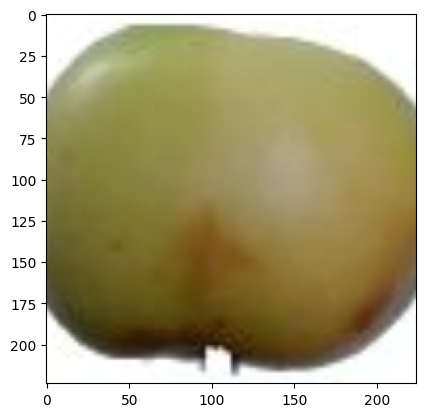

In [0]:
# Define a transform that resizes the image to a larger size before cropping and darkens the image
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to a larger size
    transforms.CenterCrop(224),     # Then crop to the desired size
    # transforms.ColorJitter(brightness=0.25),  # Darken the image
    transforms.ToTensor()
])

# Provide the correct path to the training data
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
train_dataloader_aug = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)
test_dataloader_aug = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get the first batch of images from the dataloader  
images, labels = next(iter(train_dataloader_aug))  
  
# Select the first image in the batch  
image = images[5]  
  
# Convert the PyTorch tensor to a numpy array  
image = np.transpose(image.numpy(), (1, 2, 0))  
  
# Plot the image  
plt.imshow(image)  
plt.show()

Fully Connected Model1: Below model is to modify the fully connected (fc) layer of a pre-trained GoogleNet model in PyTorch by adding layers as below:

First layer is added to the sequential module with 1024 input features and 512 output features.
To reduce non-linearity and improve learning of model on complex patterns, a ReLu activation function is added in second layer to act on the output of the first layer
Third layer is added with drop out to reduce overfitting of the model by randomly dropping out some of the neurons during training for regularization.
Forth layer is added to generate output having total classes = number of classes in original dataset.
Last layer is added to take Log of SoftMax function on probability of the prediction belonging to each class. By doing this, in this baseline model is replacing the original fc layer of the pre-trained GoogleNet model with the new sequential module.

In [0]:
model.fc = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.MaxPool1d(kernel_size=2),
                                 nn.Linear(256, len(class_names)),
                                 nn.Softmax(dim=1)).to(device)

In [0]:
loss_fn=nn.CrossEntropyLoss()

optimizer=torch.optim.SGD(params=model.parameters(),lr=0.1)

In [0]:
from timeit import default_timer as timer
start_time=timer()
device = "cuda" if torch.cuda.is_available() else "cpu"
results_model_fc=train(model=model,
                    train_dataloader=train_dataloader_aug,
                    test_dataloader=test_dataloader_aug,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=5,
                    device=device)
end_time=timer()
print(f"[INFO]Total training time= {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:0| train_loss:4.9482|train_acc:0.0150|test_loss:4.9484|test_acc:0.0041
Epoch:1| train_loss:4.9454|train_acc:0.0161|test_loss:4.9498|test_acc:0.0104
Epoch:2| train_loss:4.9507|train_acc:0.0094|test_loss:4.9500|test_acc:0.0070
Epoch:3| train_loss:4.9481|train_acc:0.0126|test_loss:4.9431|test_acc:0.0139
Epoch:4| train_loss:4.9463|train_acc:0.0145|test_loss:4.9495|test_acc:0.0104
[INFO]Total training time= 8995.584 seconds


Conclusion on Experiment #1: Compared to the baseline, test_accuracy of this model is pretty low, when it is trained for 5 epochs.